# Memory Based Collaborative Filtering

In [228]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

## User-Rating Matrix

The ratings matrix is denoted by `R` and it is an `m` by `n` matrix containing `m` users and `n` items. The rating of user `u1` for item `i3` is denoted by `r13`.

$$ U = \{ u_1, u_2 ... u_m \} \land |U| = m $$

$$ I = \{ i_1, i_2 ... i_n \} \land |I| = n $$

$$ R = \{ r_{1,1}, r_{1,2} ... r_{2,1}, r_{2,2} ... r_{m,n} \} \land |R| = m \times n $$

In [219]:
USERS: int = 10
ITEMS: int = 15

MIN_RATING: int = 0
MAX_RATING: int = 5
    
MIN_SHARED_RATINGS: int = 3

In [169]:
ratings: np.matrix = MAX_RATING * np.random.randn(USERS, ITEMS)
ratings[ratings < MIN_RATING] = np.nan
ratings[ratings > MAX_RATING] = MAX_RATING
ratings = np.floor(ratings)
print(ratings)

[[ 2. nan nan nan nan  1. nan nan nan nan  5.  0. nan nan  3.]
 [nan  3. nan  0.  3.  5. nan nan  4. nan nan  0.  4. nan  5.]
 [nan  3. nan nan nan nan nan nan  0.  4. nan  4.  1. nan  4.]
 [nan nan nan  2. nan nan  3. nan nan  2. nan  0. nan nan  5.]
 [ 0.  4.  3. nan nan nan  4. nan nan nan nan  1.  2. nan  4.]
 [ 2. nan  1.  0. nan  1. nan  5.  1. nan nan nan  5. nan  4.]
 [nan nan nan nan nan nan nan nan  5. nan  1. nan nan  5.  1.]
 [nan nan  2. nan  5. nan  1. nan nan nan nan nan nan nan nan]
 [nan nan  3. nan nan nan nan nan  3. nan  5. nan nan nan  4.]
 [nan nan  1. nan  5.  0.  5.  5. nan  4.  0. nan nan nan nan]]


## Normalization

- https://en.wikipedia.org/wiki/Normalization_(statistics)

In statistics and applications of statistics, normalization can have a range of meanings. In the simplest cases, normalization of ratings means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

$$ \bar{\mu} = \frac{\sum\limits^{^n}_{i=1} x_i}{n}	 $$

$$ σ^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu})^2}{n}	 $$

$$ z = \frac{x_i - \bar{\mu}}{σ}	 $$

In [215]:
def normalize(matrix: np.matrix) -> np.matrix:
    """
    Normalization Function.
    Returns z-score of each element in the input matrix.
    """    
    sample_size: np.array = np.sum(~np.isnan(matrix), axis=1)
    sample_size[sample_size == 0] = 1    
    averages: np.array = np.nansum(matrix, axis=1) / sample_size
    averages = averages.reshape(averages.shape[0], 1)
    variance: np.matrix = np.nansum(np.power(matrix - averages, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    standard: np.matrix = np.sqrt(variance)
    normalized: np.matrix = (matrix - averages) / standard
    return normalized

ORIGINAL [[ 1.10129357  1.5467288   0.85969813  5.71713517  4.94698707  7.1068701
   6.17702896  8.93483263  8.6862052   9.89655217]
 [20.90318138 26.79164596 32.7118289  40.32557424 45.21620457 53.7983873
  59.91340375 66.77808721 73.51682646 80.33669763]]
NORMALIZED [[-1.38200392 -1.24197033 -1.45795543  0.0691002  -0.17301493  0.50599779
   0.2136792   1.08066308  1.00250089  1.38300344]
 [-1.52074456 -1.21329247 -0.90418427 -0.50665077 -0.2512982   0.19679995
   0.51608091  0.87450394  1.2263511   1.58243436]]


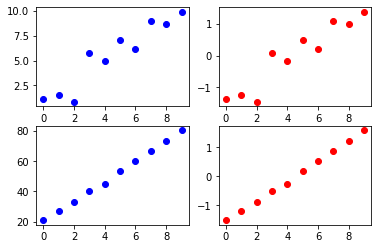

In [216]:
x: np.matrix = np.vstack([
    np.linspace(0, 10, 10) + np.random.normal(0, 1, 10),
    20 + np.linspace(0, 60, 10) + np.random.normal(0, 1, 10),
])
y = normalize(x)
assert x.shape == y.shape
print('ORIGINAL', x)
print('NORMALIZED', y)
grid = np.arange(x.shape[1])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot(2, 2, 1)
axes.plot(grid, x[0].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 2)
axes.plot(grid, y[0].flat, 'o', color='red')
axes: Axes = figure.add_subplot(2, 2, 3)
axes.plot(grid, x[1].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 4)
axes.plot(grid, y[1].flat, 'o', color='red')
plt.show()

## Cosine Similarity

- https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$ cos(X, Y) = \frac{X \cdot Y}{ \left \Vert X \right \| \cdot \left \Vert Y \right \| } = = \frac{ \sum\limits^{^n}_{i=1} X_i \cdot Y_i }{ \sqrt{\sum\limits^{^n}_{i=1} X_i^2} \cdot \sqrt{\sum\limits^{^n}_{i=1} Y_i^2} } $$

In [237]:
def cosine(X: np.array, Y: np.array) -> float:
    """
    Cosine Similarity function.
    """
    union: np.array = ~np.isnan(np.sum([X, Y], axis=0))
    if np.count_nonzero(union) == 0:
        return 0
    discount: float = min(MIN_SHARED_RATINGS, np.count_nonzero(union)) / MIN_SHARED_RATINGS
    return discount * np.sum(X[union] * Y[union]) / \
        (np.sqrt(np.sum(np.power(X[union], 2))) * np.sqrt(np.sum(np.power(Y[union], 2))))

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 1.  3.  2.  2. nan  8.  9. 10. 11. 12.] 0.9929196160911488


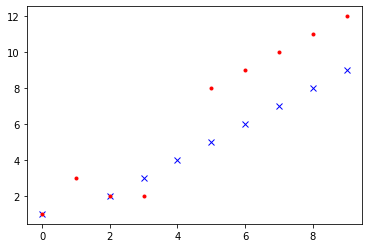

In [265]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([1, 3, 2, 2, np.nan, 8, 9, 10, 11, 12])
print(X, Y, cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 10.  30.  20.  20.  nan  80.  90. 100. 110. 120.] 0.9929196160911488


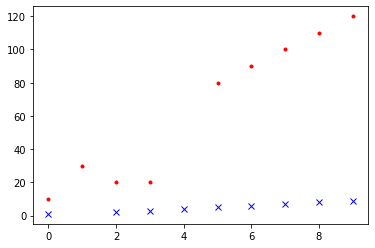

In [267]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([10, 30, 20, 20, np.nan, 80, 90, 100, 110, 120])
print(X, Y, cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  7.  9. 10.] [100.  65.  32.  24.  nan  10.   7.   4.   2.] 0.21975098781417202


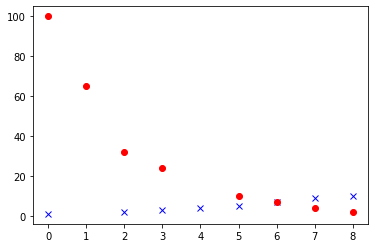

In [264]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 7, 9, 10])
Y: np.array = np.array([100, 65, 32, 24, np.nan, 10, 7, 4, 2])
print(X, Y, cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, 'o', color='red')
plt.show()

In [268]:
def similarity(matrix: np.matrix) -> np.matrix:
    """
    Get similarity matrix out of a given matrix.
    """
    return matrix


X = np.matrix([ [1,2,3], [4, 5, 6], [7,8,9] ])
S = similarity(X)
print(X)
print(S)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]


## User-Based Collaborative Filtering

In [170]:
print('USER-USER MATRIX', ratings)
normalized: np.matrix = normalize(ratings)
print('USER-USER NORMALIZED MATRIX', normalized)

USER-USER MATRIX [[ 2. nan nan nan nan  1. nan nan nan nan  5.  0. nan nan  3.]
 [nan  3. nan  0.  3.  5. nan nan  4. nan nan  0.  4. nan  5.]
 [nan  3. nan nan nan nan nan nan  0.  4. nan  4.  1. nan  4.]
 [nan nan nan  2. nan nan  3. nan nan  2. nan  0. nan nan  5.]
 [ 0.  4.  3. nan nan nan  4. nan nan nan nan  1.  2. nan  4.]
 [ 2. nan  1.  0. nan  1. nan  5.  1. nan nan nan  5. nan  4.]
 [nan nan nan nan nan nan nan nan  5. nan  1. nan nan  5.  1.]
 [nan nan  2. nan  5. nan  1. nan nan nan nan nan nan nan nan]
 [nan nan  3. nan nan nan nan nan  3. nan  5. nan nan nan  4.]
 [nan nan  1. nan  5.  0.  5.  5. nan  4.  0. nan nan nan nan]]
USER-USER NORMALIZED MATRIX [[-0.11624764         nan         nan         nan         nan -0.69748583
          nan         nan         nan         nan  1.62746694 -1.27872403
          nan         nan  0.46499055]
 [        nan  0.                 nan -1.60356745  0.          1.06904497
          nan         nan  0.53452248         nan         nan -

In [81]:
def collaborative_filtering(ratings: np.matrix) -> np.matrix:
    """
    Collaborative Filtering method.
    """
    
    # Start of Collaborative Filtering.
    print('INPUT', ratings)
    
    # Row sample size
    sample_size: np.array = np.sum(~np.isnan(ratings), axis=1)
    sample_size[sample_size == 0] = 1
    print('SIZE', sample_size)
    
    # Row Average
    averages: np.array = np.nansum(ratings, axis=1) / sample_size
    averages = averages.reshape(averages.shape[0], 1)
    print('AVERAGE', averages)

    # Row Variance
    variance: np.matrix = np.nansum(np.power(ratings - averages, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    print('VARIANCE', variance)
    
    # Mean Average Ratings
    adjusted_ratings: np.matrix = ratings - averages / variance
    print('ADJUSTED', adjusted_ratings)
    
    # End of Collaborative Filtering
    # print('OUTPUT', ratings)
    return ratings

collaborative_filtering(RATINGS)
print(RATINGS)

INPUT [[nan  5.  3. nan nan  0.]
 [ 5. nan  5. nan nan nan]
 [nan nan nan nan  1.  1.]
 [nan nan nan  3.  1. nan]
 [nan nan nan  2.  0.  0.]]
SIZE [3 2 2 2 3]
AVERAGE [[2.66666667]
 [5.        ]
 [1.        ]
 [2.        ]
 [0.66666667]]
VARIANCE [[4.22222222]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.88888889]]
ADJUSTED [[        nan  4.36842105  2.36842105         nan         nan -0.63157895]
 [ 0.                 nan  0.                 nan         nan         nan]
 [        nan         nan         nan         nan  0.          0.        ]
 [        nan         nan         nan  1.         -1.                 nan]
 [        nan         nan         nan  1.25       -0.75       -0.75      ]]
[[nan  5.  3. nan nan  0.]
 [ 5. nan  5. nan nan nan]
 [nan nan nan nan  1.  1.]
 [nan nan nan  3.  1. nan]
 [nan nan nan  2.  0.  0.]]


## Memory-Based Collaborative Filtering